#### Projet PAO Python par Nils Cercariolo, Tenga Cortal et Adrien Pasquesoone

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#On charge le dataset 
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD9V0GH/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteD9V0GH/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
#On définit une fonction qui réduit l'image pour travailler avec une dimension fixe de 128x128
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

In [ ]:
#On définit une fonction qui 1 fois sur 2 retourne l'image et le masque pour rendre le modèle plus robuse
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [ ]:
#On créé la fonction de normalisation
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [ ]:
#Fonction pour charger une image du training set
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

#Fonction pour charger une image du test set
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
#On créé les datasets de train et de test de manière optimisée avec tensor flow
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64 #Taille d'un batch
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #On mélange les données
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE) #On prefetch pour pouvoir utiliser la parallélisation et accélerer les calculs
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE) #On prélève 3000 données du dataset test pour en faire un batch de validation
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE) #On saute les 3000 premières données car elles seront réservés au validation set donc à la 
                                                                   #détermination des hyperparamètres. Ensuite on prend au maximum 669 données pour faire les batchs
                                                                   #de chacun max 64

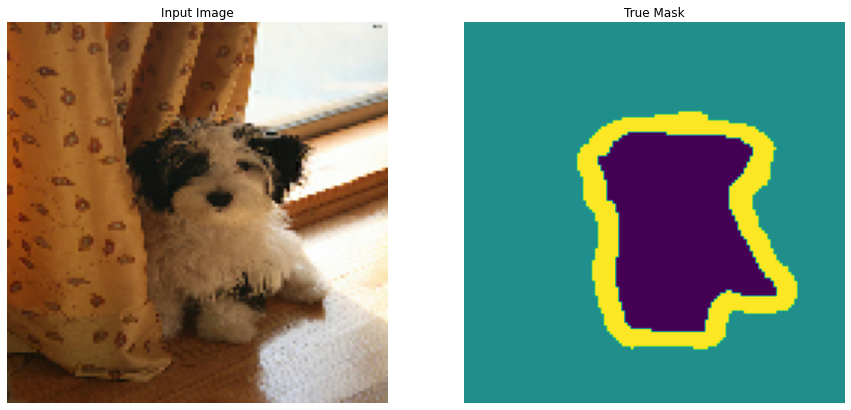

In [ ]:
#Définition de la fonction d'affichage
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

sample_batch = next(iter(train_batches)) #On prend un batch
random_index = np.random.choice(sample_batch[0].shape[0]) #On créé un indice aléatoire
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index] #On détermine l'image et son masque dans ce batch grâce à l'indice
display([sample_image, sample_mask]) #On affiche les images

In [ ]:
#On commence a créér nos différentes couches avec un block de 2 couches convolutives utilisant la fonction d'activatin ReLU
def double_conv_block(x, n_filters):

    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
#Fonction pour diminuer les échantillons de l'entrée en en supprimant
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f) #Pooling pour réduire les dimensions des caractéristiques
    p = layers.Dropout(0.3)(p) #Avec un taux de 0.3, on met des 0 dans les entrées pour éviter l'overfitting

    return f, p

In [ ]:
#Fonction qui augmente la résolution spatiale des images
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x) #On fait le procédé inverse de la convolution, aussi appelé déconvolution
    x = layers.concatenate([x, conv_features]) #On concatène x et les caractéristiques de convolution
    x = layers.Dropout(0.3)(x) #Avec un taux de 0.3, on met des 0 dans les entrées pour éviter l'overfitting
    x = double_conv_block(x, n_filters) #Double convolution

    return x

In [ ]:
#On créé la fonction pour créér le modèle unet suivant l'illustration de ce lien : https://developers.arcgis.com/python/guide/how-unet-works/
def build_unet_model():     
    inputs = layers.Input(shape=(128,128,3))
    #Partie encodeur
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    #Partie décodeur
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9) #On calcule les sorties avec une fonction d'actiation softmax
    # On créé le model unet avec keras en donnant les entrées et les sorties
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model = build_unet_model() #On construit le modèle

In [ ]:
#Configure le modèle pour l'apprentissage
unet_model.compile(optimizer=tf.keras.optimizers.Adam(), #Optimiseur qui implémente l'algorithme Adam
                  loss="sparse_categorical_crossentropy", #On choisit cette loss function car on a plusieurs classes de labels
                  metrics="accuracy") #On prend comme métrique la précision car c'est le plus visuel et le plus simple dans un premier temps

In [ ]:
NUM_EPOCHS = 35 #Hyperparamètre qui définit le nombre de fois où l'algorithme d'apprentissage travaillera sur l'ensemble des données d'apprentissage. 
TRAIN_LENGTH = info.splits["train"].num_examples #On définit le nombre d'exemple pour le dataset d'apprentissage
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE #Nombre d'étapes par epoch
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples #On définit le nombre d'exemple pour le dataset de test
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS #Nombre d'étapes par validation
model_history = unet_model.fit(train_batches, #On entraine notre modèle en lui renseignant les caractéristiques calculées avant
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/35
57/57 [==============================] - 91s 1s/step - loss: 0.9195 - accuracy: 0.5793 - val_loss: 0.8062 - val_accuracy: 0.6305
Epoch 2/35
57/57 [==============================] - 72s 1s/step - loss: 0.7079 - accuracy: 0.7026 - val_loss: 0.6307 - val_accuracy: 0.7389
Epoch 3/35
57/57 [==============================] - 64s 1s/step - loss: 0.6118 - accuracy: 0.7538 - val_loss: 0.5552 - val_accuracy: 0.7779
Epoch 4/35
57/57 [==============================] - 64s 1s/step - loss: 0.5530 - accuracy: 0.7828 - val_loss: 0.5593 - val_accuracy: 0.7948
Epoch 5/35
57/57 [==============================] - 64s 1s/step - loss: 0.4913 - accuracy: 0.8091 - val_loss: 0.4493 - val_accuracy: 0.8258
Epoch 6/35
57/57 [==============================] - 63s 1s/step - loss: 0.4543 - accuracy: 0.8254 - val_loss: 0.4316 - val_accuracy: 0.8343
Epoch 7/35
57/57 [==============================] - 64s 1s/step - loss: 0.4256 - accuracy: 0.8363 - val_loss: 0.3985 - val_accuracy: 0.8473
Epoch 8/35
57/57 [==

In [ ]:
#Fonction pour créer le masque prédit par notre modèle
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

    #Fonction pour comparer l'image d'entrée, la vérité terrain et ce qu'on a calculé avec notre modèle. On en montre 10 pour visualiser un panel de nos résultats
def show_predictions():
    for _ in range(10):
        sample_batch = next(iter(train_batches))
        random_index = np.random.choice(sample_batch[0].shape[0])
        sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
        display([sample_image, sample_mask,
                create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


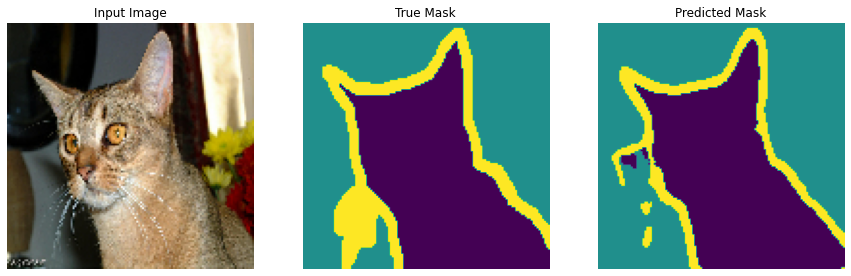

1/1 [==============================] - 0s 17ms/step


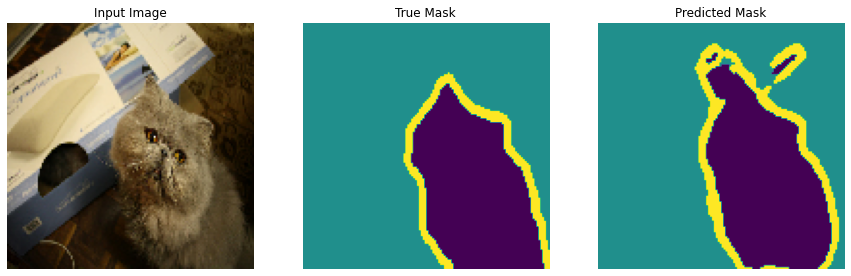

1/1 [==============================] - 0s 26ms/step


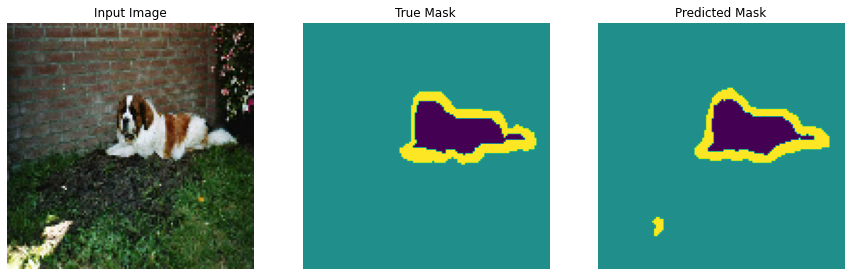

1/1 [==============================] - 0s 17ms/step


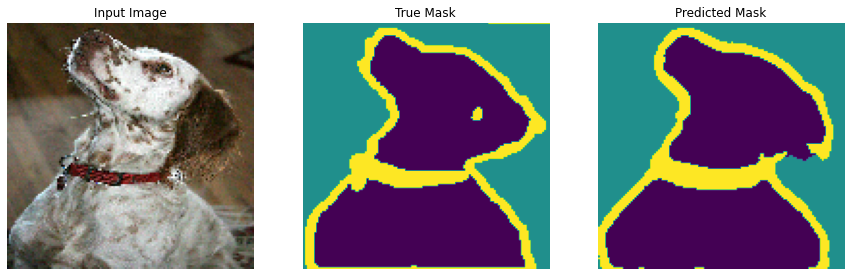

1/1 [==============================] - 0s 20ms/step


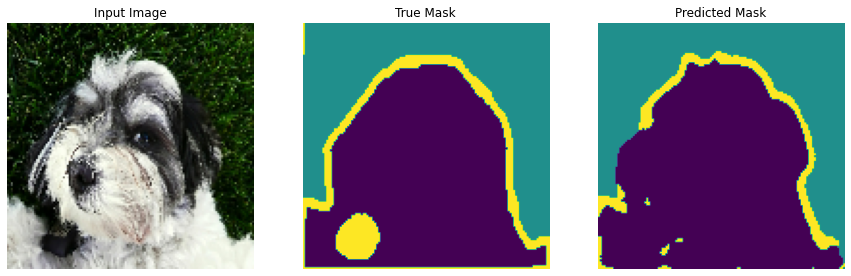

1/1 [==============================] - 0s 18ms/step


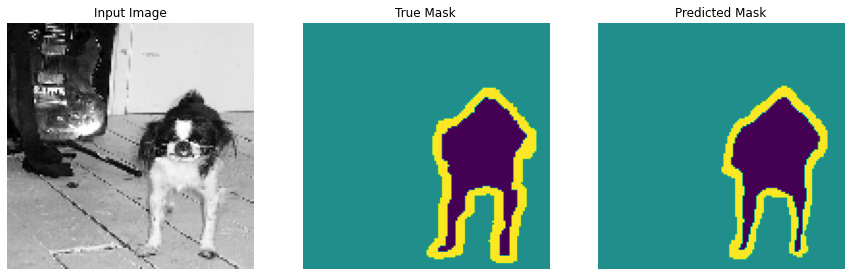

1/1 [==============================] - 0s 20ms/step


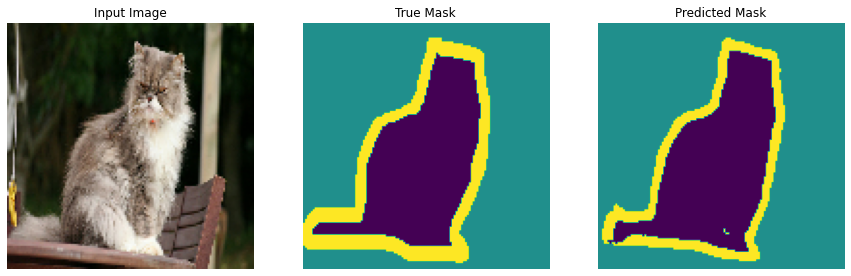

1/1 [==============================] - 0s 17ms/step


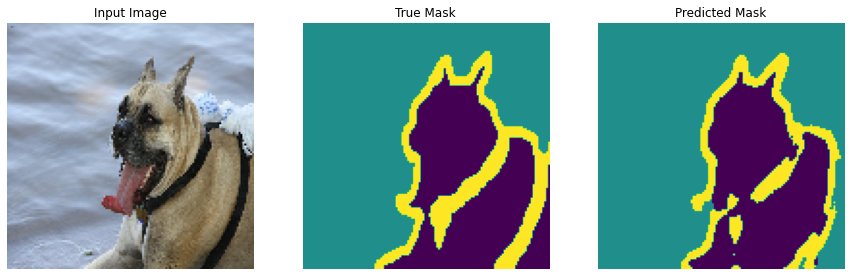

1/1 [==============================] - 0s 19ms/step


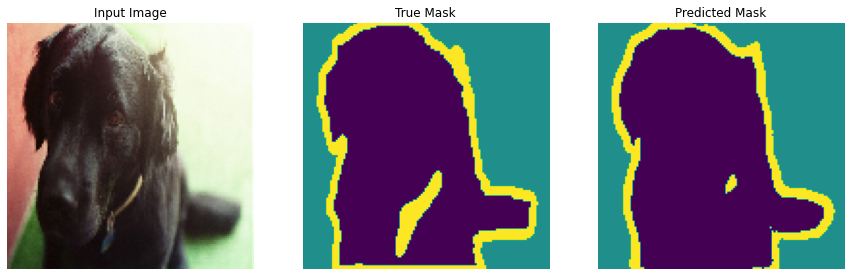

1/1 [==============================] - 0s 18ms/step


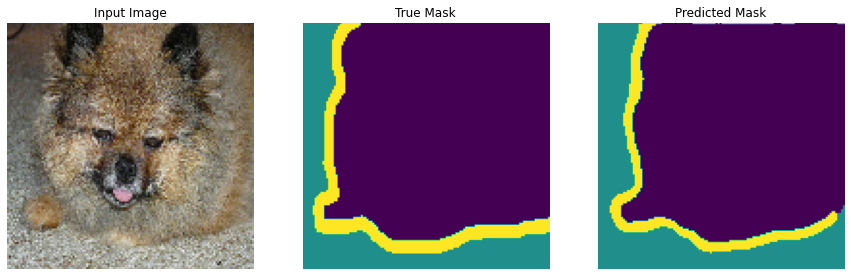

In [ ]:
show_predictions() #On trouve un plateau vers 35 epochs qui donne environ 91%/92% de précision pour environ 40 minutes de calcul (avec GPU).
                   #En revanche meme avec 20 epochs on obtient légèrement moins de 90% pour 20 minutes de calcul (avec GPU).
                   #Pour un autre modèle on pourrait donc laisser le nombre à 20 car il est préférable d'économiser la ressource GPU vu le peu de gain à 35 epochs mais
                   #encore une fois, tout dépend de l'application.